# Вывод результатов в матрицу смежности

In [1]:
import osmnx as ox
import numpy as np
import geopandas as gpd
import pandas as pd
import os
from blocksnet import AdjacencyCalculator

Загружаем датасет трафика и транспортный граф ВО

In [2]:
traffic = np.load('./data/traffic_9_10_11_month_work_hours.npz')
G = ox.load_graphml("./data/drive.graphml")

- ``arr_0`` - скорость
- ``arr_1`` - время
- ``arr_2`` - дата
- ``arr_3`` - день недели

In [3]:
print(traffic.files)
dataset_speeds = traffic['arr_0']

['arr_0', 'arr_1', 'arr_2', 'arr_3']


In [4]:
from IPython.display import clear_output

# Формирование дорожного графа
def get_new_graph(speed, graph):
    node, edges = ox.graph_to_gdfs(graph)
    edges['speed'] = speed
    edges.weight = edges.length / (edges.speed * 1000 / 60) 
    new_graph = ox.graph_from_gdfs(node, edges)
    return new_graph

# Формирование серии графов в течении дня
def get_road_graphs_during_day(speeds, graph):
    hours = range(len(speeds))
    
    def _get_new_graph(hour):
        new_graph = get_new_graph(speeds[hour], graph)
        clear_output(wait=True)
        print(hour, len(speeds))
        return new_graph
    
    return [_get_new_graph(hour) for hour in hours]
    

In [5]:
graphs = get_road_graphs_during_day(dataset_speeds, G)

1124 1125


Now me make some adjacency matrices

In [6]:

def weight_to_float(graph):
  for u, v, data in graph.edges(data=True):
    data['weight'] = float(data['weight'])

In [14]:
blocks = gpd.read_parquet('./data/blocks.parquet')

def graph_to_adj_mx(graph, blocks):
  adj = AdjacencyCalculator(blocks=blocks, graph=graph)
  return adj.get_dataframe()

adj_matrices = [graph_to_adj_mx(graph, blocks) for graph in graphs[:24]]

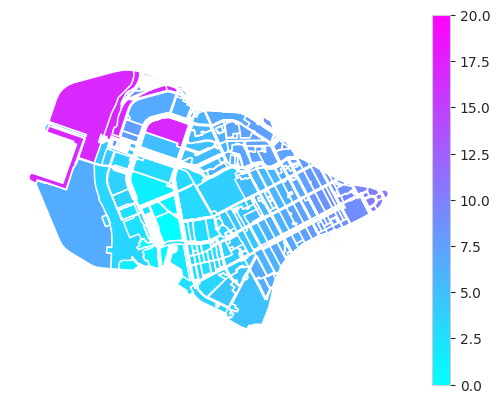

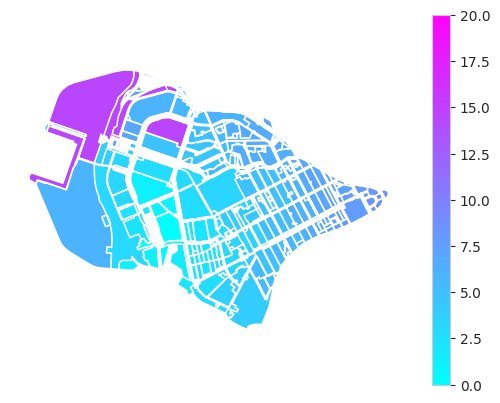

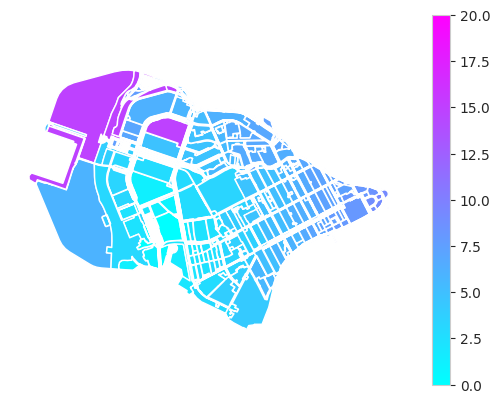

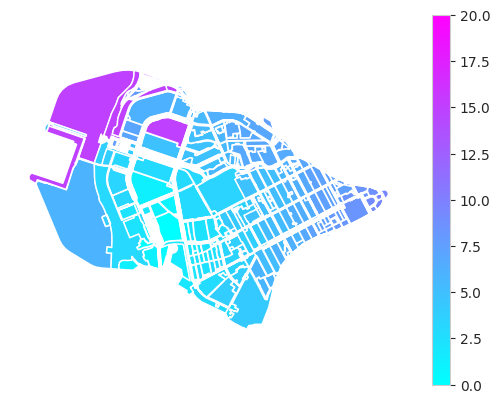

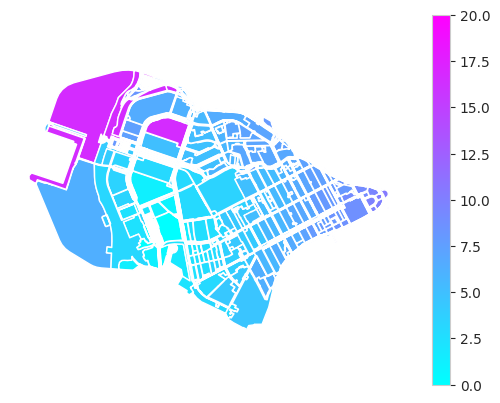

In [21]:
from blocksnet import City, Accessibility

for adj_mx in adj_matrices[:5]:
  city = City(blocks_gdf=blocks, adjacency_matrix=adj_mx)
  acc = Accessibility(city_model=city)
  calc = acc.calculate(0)
  calc.plot(column="distance", cmap="cool", legend=True, vmin=0, vmax=20).set_axis_off()

In [ ]:
from google.colab import files
for hour in range(5):
  files.download(f'/content/predict_traffic/ac_matrix_4{hour}.pickle')

In [ ]:
# Формирование дорожного графа
def get_new_graph(speed, graph, path_to_save):
    node, edges = ox.graph_to_gdfs(graph)
    edges['speed'] = speed
    for i in range(len(edges)):
        edges['weight'].iloc[i] = edges['length'].iloc[i]/(edges['speed'].iloc[i]*(1000/60))
    new_graph = ox.graph_from_gdfs(node, edges)
    ox.save_graphml(new_graph, path_to_save)

# Формирование серии графов в течении дня
def get_road_graphs_during_day(day, hours_per_day, speeds_dataset, graph, path_folder):
    for hour in range(hours_per_day):
        speed = speeds_dataset[day*hours_per_day+hour]
        path_to_save_file = f'{path_folder}/road_graph_{day}_{hour}.graphml'
        get_new_graph(speed, graph, path_to_save_file)


In [ ]:
# Получим графы 21.09.2023 (четверг)
day = 20
hours = 15
date = np.load('/content/traffic_9_10_11_month_work_hours.npz')['arr_2']
week_day = np.load('/content/traffic_9_10_11_month_work_hours.npz')['arr_3']
print(date[day*hours] + ' ' + week_day[day*hours])

get_road_graphs_during_day(day, hours, dataset_speeds, G, '/content/graphml')

In [ ]:
blocks = gpd.read_parquet('/content/blocks_cutter_result.parquet')

def weight_to_float(graph):
  for u, v, data in graph.edges(data=True):
    data['weight'] = float(data['weight'])

In [ ]:
for hour in range(hours):
  name_file = f'/content/graphml/road_graph_{day}_{hour}.graphml'
  name = f'ac_matrix_{day}_{hour}.pickle'
  g = ox.load_graphml(name_file)
  weight_to_float(g)
  accessibility_matrix = AdjacencyCalculator(blocks=blocks, graph=g).get_dataframe()
  accessibility_matrix.to_pickle(os.path.join('/content/ac_matrix/', name))

In [ ]:
accessibility_matrix = pd.read_pickle("/content/ac_matrix/ac_matrix_20_0.pickle")
accessibility_matrix

In [ ]:
accessibility_matrix2 = pd.read_pickle("/content/ac_matrix/ac_matrix_20_10.pickle")
accessibility_matrix2